In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import preprocess as pre

In [2]:
users_file = "BX-Users.csv"
books_file = "BX-Books.csv"
rating_file = "BX-Ratings.csv"
new_users_file = "BX-NewBooksUsers.csv"
new_books_file = "BX-NewBooks.csv"
new_ratings_file = "BX-NewBooksRatings.csv"

,User-ID_x,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating_x,User-ID_y,Book-Rating_y
0,241118,san diego,california,"usa""",5.0,0-10,0140075569,5,16634,8
1,241118,san diego,california,"usa""",5.0,0-10,0140075569,5,83671,7
2,241118,san diego,california,"usa""",5.0,0-10,0140075569,5,111019,7
3,241118,san diego,california,"usa""",5.0,0-10,0140075569,5,173415,8
4,241118,san diego,california,"usa""",5.0,0-10,0140075569,5,206534,8
...,...,...,...,...,...,...,...,...,...,...
8591181,14449,saskatoon,saskatchewan,"canada""",72.0,70-80,0312853807,8,160697,7
8591182,158606,dunedin,florida,"usa""",72.0,70-80,0312853807,10,14449,8
8591183,158606,dunedin,florida,"usa""",72.0,70-80,0312853807,10,118632,7
8591184,158606,dunedin,florida,"usa""",72.0,70-80,0312853807,10,158606,10


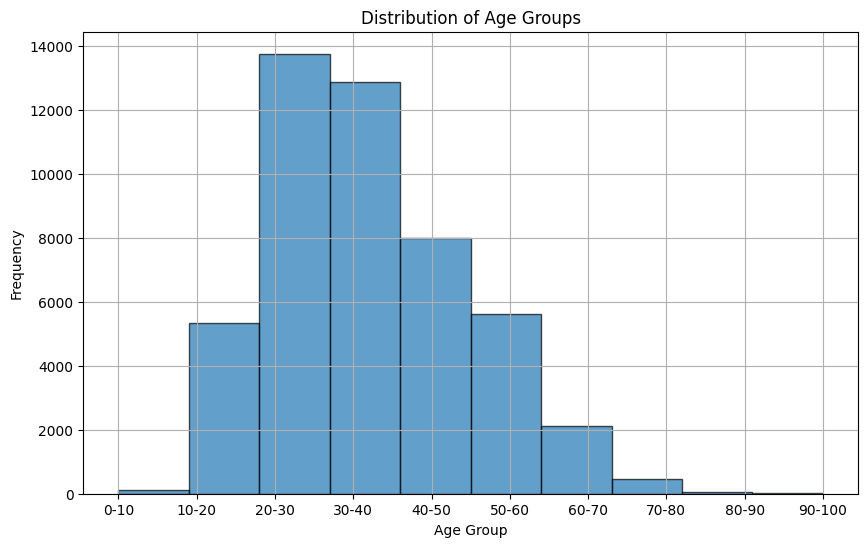

In [4]:
users_df = pd.read_csv(users_file)
ratings_df = pd.read_csv(rating_file)
books_df = pd.read_csv(rating_file)

users_df = pre.imputation(pre.weighted_age_dict(users_file), users_df)
merged_df = pre.discretising(users_df, ratings_df, books_df)
merged_df